# Data Analysis: Reports of tumours

In this document, we will look at the given data.

## Importing the Data

In [1]:
import sys
import os

# Append parent directory to path
sys.path.append("..")

# Change to parent directory
os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lib.load_dataset import get_original_dataset, get_ready_data

sns.set_theme()


data_by_expert = get_original_dataset(which="2019-2021")
data_ready = get_ready_data(which="2019-2021")


# Get report count of each patient
data_by_expert["RecordCount"] = pd.merge(
    data_by_expert["HlaseniIdDtb"],
    data_ready[["RecordId", "RecordCount"]],
    left_on="HlaseniIdDtb",
    right_on="RecordId",
    how="left",
)["RecordCount"]


"""
Take only patients with more than 1 record.
The patients with one record are artefacts from removing rejected records 
before storing the data.
"""
print(
    "Number of records with one record:",
    data_ready[data_ready["RecordCount"] == 1].shape[0],
)

print(
    "Number of filtered records:",
    data_ready[data_ready["AlgoFiltered"] == 1].shape[0],
)

# data_ready = data_ready[data_ready["RecordCount"].between(2, 3)]

# Algorithmic filtering
assert (
    data_by_expert["HlaseniIdDtb"] == data_ready["RecordId"]
).sum() == data_by_expert.shape[0]

data_by_expert = data_by_expert[
    (data_ready["AlgoFiltered"] == 0)
    & (data_ready["RecordCount"].between(2, 3))
]

# Not filtered by record count in range 2-3
data_ready_only_algo_filtered = data_ready[
    (data_ready["AlgoFiltered"] == 0) & (data_ready["RecordCount"] > 1)
].copy()

data_ready = data_ready[
    (data_ready["AlgoFiltered"] == 0)
    & (data_ready["RecordCount"].between(2, 3))
]

data_ready.drop(columns="AlgoFiltered", inplace=True)

data_by_expert["DgKod_first_3"] = data_by_expert["DgKod"].str[:3]

print("By expert data shape:", data_by_expert.shape)

Number of records with one record: 1696
Number of filtered records: 2995
By expert data shape: (21297, 81)


In [3]:
data_ready["FinalDecision"].value_counts(normalize=True)

FinalDecision
1    0.795934
0    0.204066
Name: proportion, dtype: float64

## ICD

We look at the `ICD` column, which contains the diagnosis code of the tumour in ICD-10 format.

In [14]:
dg_codes = data_by_expert["DgKod"]

print("Number of unique dg codes:", dg_codes.nunique())

Number of unique dg codes: 535


In [15]:
print(
    "Number of unique first three letters of dg code:",
    dg_codes.str[:3].nunique(),
)

Number of unique first three letters of dg code: 121


### Frequency of ICD

In [16]:
# Group dg_codes
group_by_col = "DgKod_first_3"
# group_by_col = "DgKod"
dg_codes_grouped = data_by_expert.groupby(group_by_col).size().rename("count")
dg_codes_grouped = pd.concat(
    [
        dg_codes_grouped,
        data_by_expert.groupby(group_by_col)["vyporadani_final"]
        .sum()
        .rename("accepted")
        .astype(int),
    ],
    axis=1,
)
dg_codes_grouped["unaccepted"] = (
    dg_codes_grouped["count"] - dg_codes_grouped["accepted"]
)

print("Shape of dg_codes_grouped:", dg_codes_grouped.shape)
dg_codes_grouped.sort_values(by="count", ascending=False).head(10)

Shape of dg_codes_grouped: (121, 3)


,count,accepted,unaccepted
DgKod_first_3,,,
C18,1625,1463,162
C34,1454,1334,120
C50,1260,1183,77
C61,1064,1007,57
C64,991,949,42
C20,946,820,126
C78,874,70,804
D05,558,293,265
D01,546,481,65


In [17]:
dg_codes_grouped.loc["C18"]

count         1625
accepted      1463
unaccepted     162
Name: C18, dtype: int64

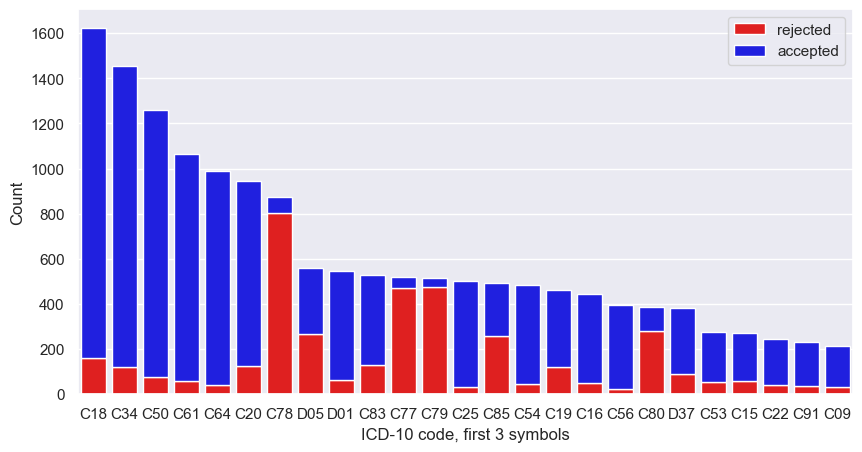

In [18]:
# Plot top dg codes together with their acceptance rate
take = 25
top_dg_codes = dg_codes_grouped.sort_values(by="count", ascending=False).head(
    take
)

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=top_dg_codes,
    x=top_dg_codes.index,
    y="unaccepted",
    ax=ax,
    color="red",
    label="rejected",
)

# Bottom plot
sns.barplot(
    data=top_dg_codes,
    x=top_dg_codes.index,
    y="accepted",
    ax=ax,
    color="blue",
    bottom=top_dg_codes["unaccepted"],
    label="accepted",
)

ax.set_ylabel("Count")
ax.set_xlabel("ICD-10 code, first 3 symbols")
# plt.title(f"Top {take} ICD-10 codes by count")

None

In [26]:
dg_codes_grouped.sort_values(
    by="unaccepted", ascending=False
).head(10)

,count,accepted,unaccepted
DgKod_first_3,,,
C78,874,70,804
C79,513,38,475
C77,520,50,470
C80,388,110,278
D05,558,293,265
C85,494,234,260
C18,1625,1463,162
C83,530,402,128
C20,946,820,126


<Axes: xlabel='ICD', ylabel='Count'>

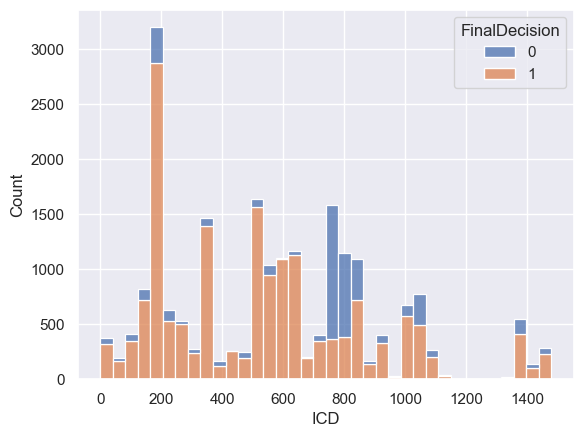

In [30]:
sns.histplot(data=data_ready, x="ICD", hue="FinalDecision", multiple="stack")

We see from the histogram that there is no pattern after sorting the diagnoses codes.

### Ranges of ICD

In [40]:
def analyze_dg_codes_in_range(a: str, b: str) -> pd.DataFrame:
    df_range = data_by_expert[
        (a <= data_by_expert["DgKod"]) & (data_by_expert["DgKod"] <= b)
    ]

    # df_range = data_by_expert.join(df_range, how="inner", rsuffix="_range")

    return df_range


def print_stats(a, b):
    df = analyze_dg_codes_in_range(a, b)
    if df.shape[0] == 0:
        print("No entries in this range")
        return

    vals = df["vyporadani_final"].value_counts()
    print(f"Range: {a} - {b}")
    print(vals)
    print(f"Percentage of not accepted: {vals[0] / vals.sum() * 100:.2f}%")
    print(
        f"Percentage of these entries in the dataset: {vals[0] / data_by_expert.shape[0] * 100:.2f}%"
    )


print_stats("C760", "C809")

Range: C760 - C809
vyporadani_final
0.0    2112
1.0     343
Name: count, dtype: int64
Percentage of not accepted: 86.03%
Percentage of these entries in the dataset: 9.92%


In [41]:
print_stats("D37", "D48")

Range: D37 - D48
vyporadani_final
1.0    689
0.0    231
Name: count, dtype: int64
Percentage of not accepted: 25.11%
Percentage of these entries in the dataset: 1.08%


In [34]:
print_stats("D00", "D48")

Range: D00 - D48
vyporadani_final
1.0    1963
0.0     744
Name: count, dtype: int64
Percentage of not accepted: 27.48%
Percentage of these entries in the dataset: 3.49%


In [35]:
print_stats("C85", "C86")

Range: C85 - C86
vyporadani_final
0.0    260
1.0    234
Name: count, dtype: int64
Percentage of not accepted: 52.63%
Percentage of these entries in the dataset: 1.22%


In [36]:
print_stats("C95", "C959")

Range: C95 - C959
vyporadani_final
0.0    9
1.0    7
Name: count, dtype: int64
Percentage of not accepted: 56.25%
Percentage of these entries in the dataset: 0.04%


In [37]:
print_stats("C00", "C209")

Range: C00 - C209
vyporadani_final
1.0    4267
0.0     738
Name: count, dtype: int64
Percentage of not accepted: 14.75%
Percentage of these entries in the dataset: 3.47%


In [38]:
print_stats("C00", "C009")

Range: C00 - C009
vyporadani_final
1.0    23
0.0     3
Name: count, dtype: int64
Percentage of not accepted: 11.54%
Percentage of these entries in the dataset: 0.01%


In [42]:
print_stats("D05", "D059")

Range: D05 - D059
vyporadani_final
1.0    293
0.0    265
Name: count, dtype: int64
Percentage of not accepted: 47.49%
Percentage of these entries in the dataset: 1.24%


## PT Column

<Axes: xlabel='PT', ylabel='Count'>

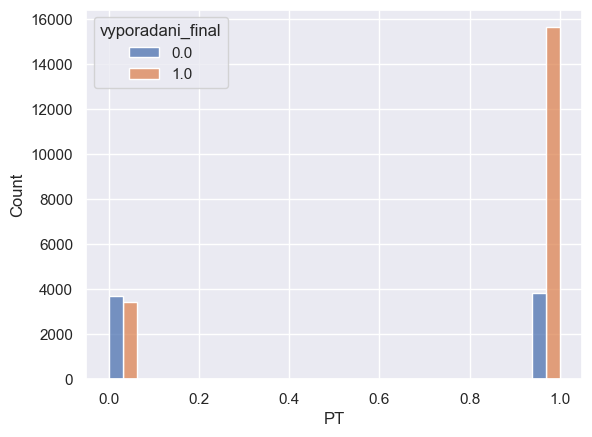

In [68]:
pt_notna = data_by_expert[["PT", "vyporadani_final"]][:]
pt_notna["PT"] = pt_notna["PT"].notna().astype(int)

sns.histplot(data=pt_notna, x="PT", hue="vyporadani_final", multiple="dodge")

## Topography

TopografieKod is part of ICD-O-3.

In [25]:
print(data_by_expert["TopografieKod"].value_counts(dropna=False).head(10))
print()
print(data_by_expert["DgKod"].value_counts(dropna=False).head(10))

TopografieKod
C809    1599
C209    1121
C619    1093
C649    1056
C421     839
C504     787
C187     670
C199     533
C569     507
C341     505
Name: count, dtype: int64

DgKod
C61     1064
C64      991
C20      946
C504     590
C187     516
C341     477
C19      463
D051     420
C787     414
C56      393
Name: count, dtype: int64


In [26]:
# Check if TopografieKod has always the same length
print("Length of TopografieKod:")
data_by_expert["TopografieKod"].str.len().value_counts(dropna=False)

Length of TopografieKod:


TopografieKod
4    21297
Name: count, dtype: int64

In [27]:
# Check if TopografieKod is same as DgKod
x = len(
    data_by_expert[data_by_expert["TopografieKod"] != data_by_expert["DgKod"]][
        ["TopografieKod", "DgKod"]
    ]
)
print(
    f"TopografieKod is different from DgKod in {x} cases: {x / data_by_expert.shape[0] * 100:.2f}%"
)

TopografieKod is different from DgKod in 11693 cases: 54.90%


## FinalDecision

In [7]:
final_false = data_by_expert[data_by_expert["vyporadani_final"] == 0]
final_true = data_by_expert[data_by_expert["vyporadani_final"] == 1]

t = len(final_true)
f = len(final_false)
print(f"True: {t}, False: {f}, Total: {t + f}")
print("Negative : positive ratio:", f / t)
print(f"True percentage: {t / (t + f):.4f}")
print(f"False percentage: {f / (t + f):.4f}")

True: 16171, False: 5126, Total: 21297
Negative : positive ratio: 0.31698719930740216
True percentage: 0.7593
False percentage: 0.2407


We can see that the most common toumor is `C61` which is "Zhoubný novotvar předstojné žlázy – prostaty".

## TypeOfCare

TypPece
03     9664
01     7127
02     4496
00        9
NaN       1
Name: count, dtype: int64


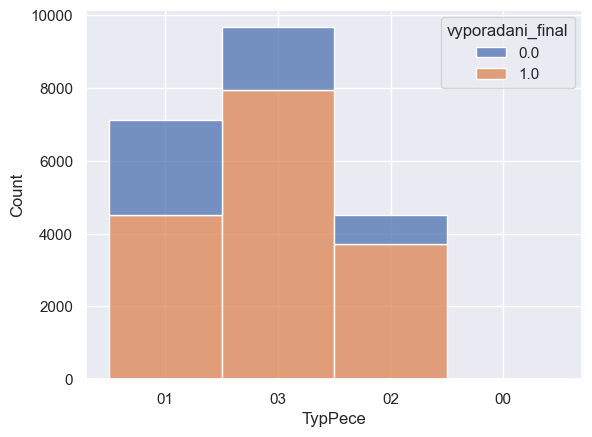

In [10]:
sns.histplot(data=data_by_expert, x="TypPece", hue="vyporadani_final", multiple="stack")

print(data_by_expert["TypPece"].value_counts(dropna=False))

## NadorId (tumor ID)

`NadorId` cannot be used as it is filled after it has been decided whether to accept the report or not.

Text(0.5, 1.0, 'Tumour ID missing')

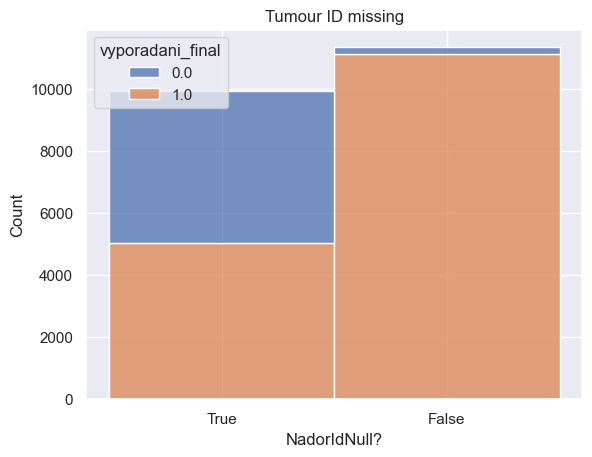

In [17]:
nador_id_null = pd.concat(
    [
        data_by_expert["NadorId"].isnull().astype(str),
        data_by_expert["vyporadani_final"],
    ],
    axis=1,
)
nador_id_null.columns = ["NadorIdNull?", "vyporadani_final"]

_, ax = plt.subplots()

sns.histplot(
    data=nador_id_null,
    x="NadorIdNull?",
    hue="vyporadani_final",
    multiple="stack",
    ax=ax,
)
ax.set_title("Tumour ID missing")

## Years

<Axes: xlabel='RokStanoveniDg', ylabel='count'>

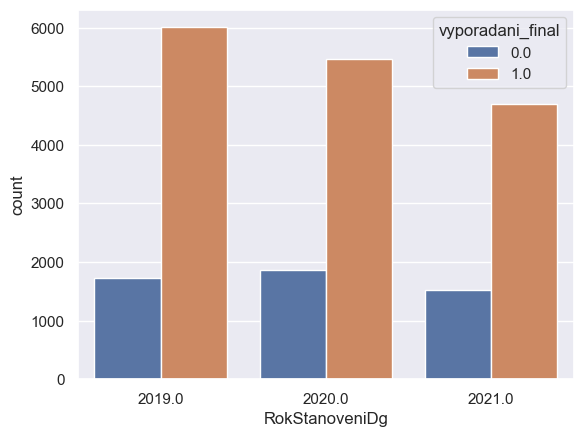

In [13]:
sns.countplot(data=data_by_expert, x="RokStanoveniDg", hue="vyporadani_final")

## Unique Values

In [18]:
# Print count of unique values for each column
print("Column, unique values count:")
d = {}
for col in data_by_expert.columns:
    d[col] = data_by_expert[col].nunique()
    # print(col, data_categorical[col].nunique())

count_table = pd.DataFrame.from_dict(d, orient="index")
count_table = count_table.sort_values(by=0, ascending=False)

# Look at specific columns
cols_to_look = [
    "DgKod",
    "MorfologieKlasifikaceKod",
]

for col in cols_to_look:
    print(col, ":", count_table.loc[col][0])

Column, unique values count:
DgKod : 535
MorfologieKlasifikaceKod : 537


## Correlations

In this section, we look at the correlations between the columns.

### DatumVyporadani

### Correlation Heatmap

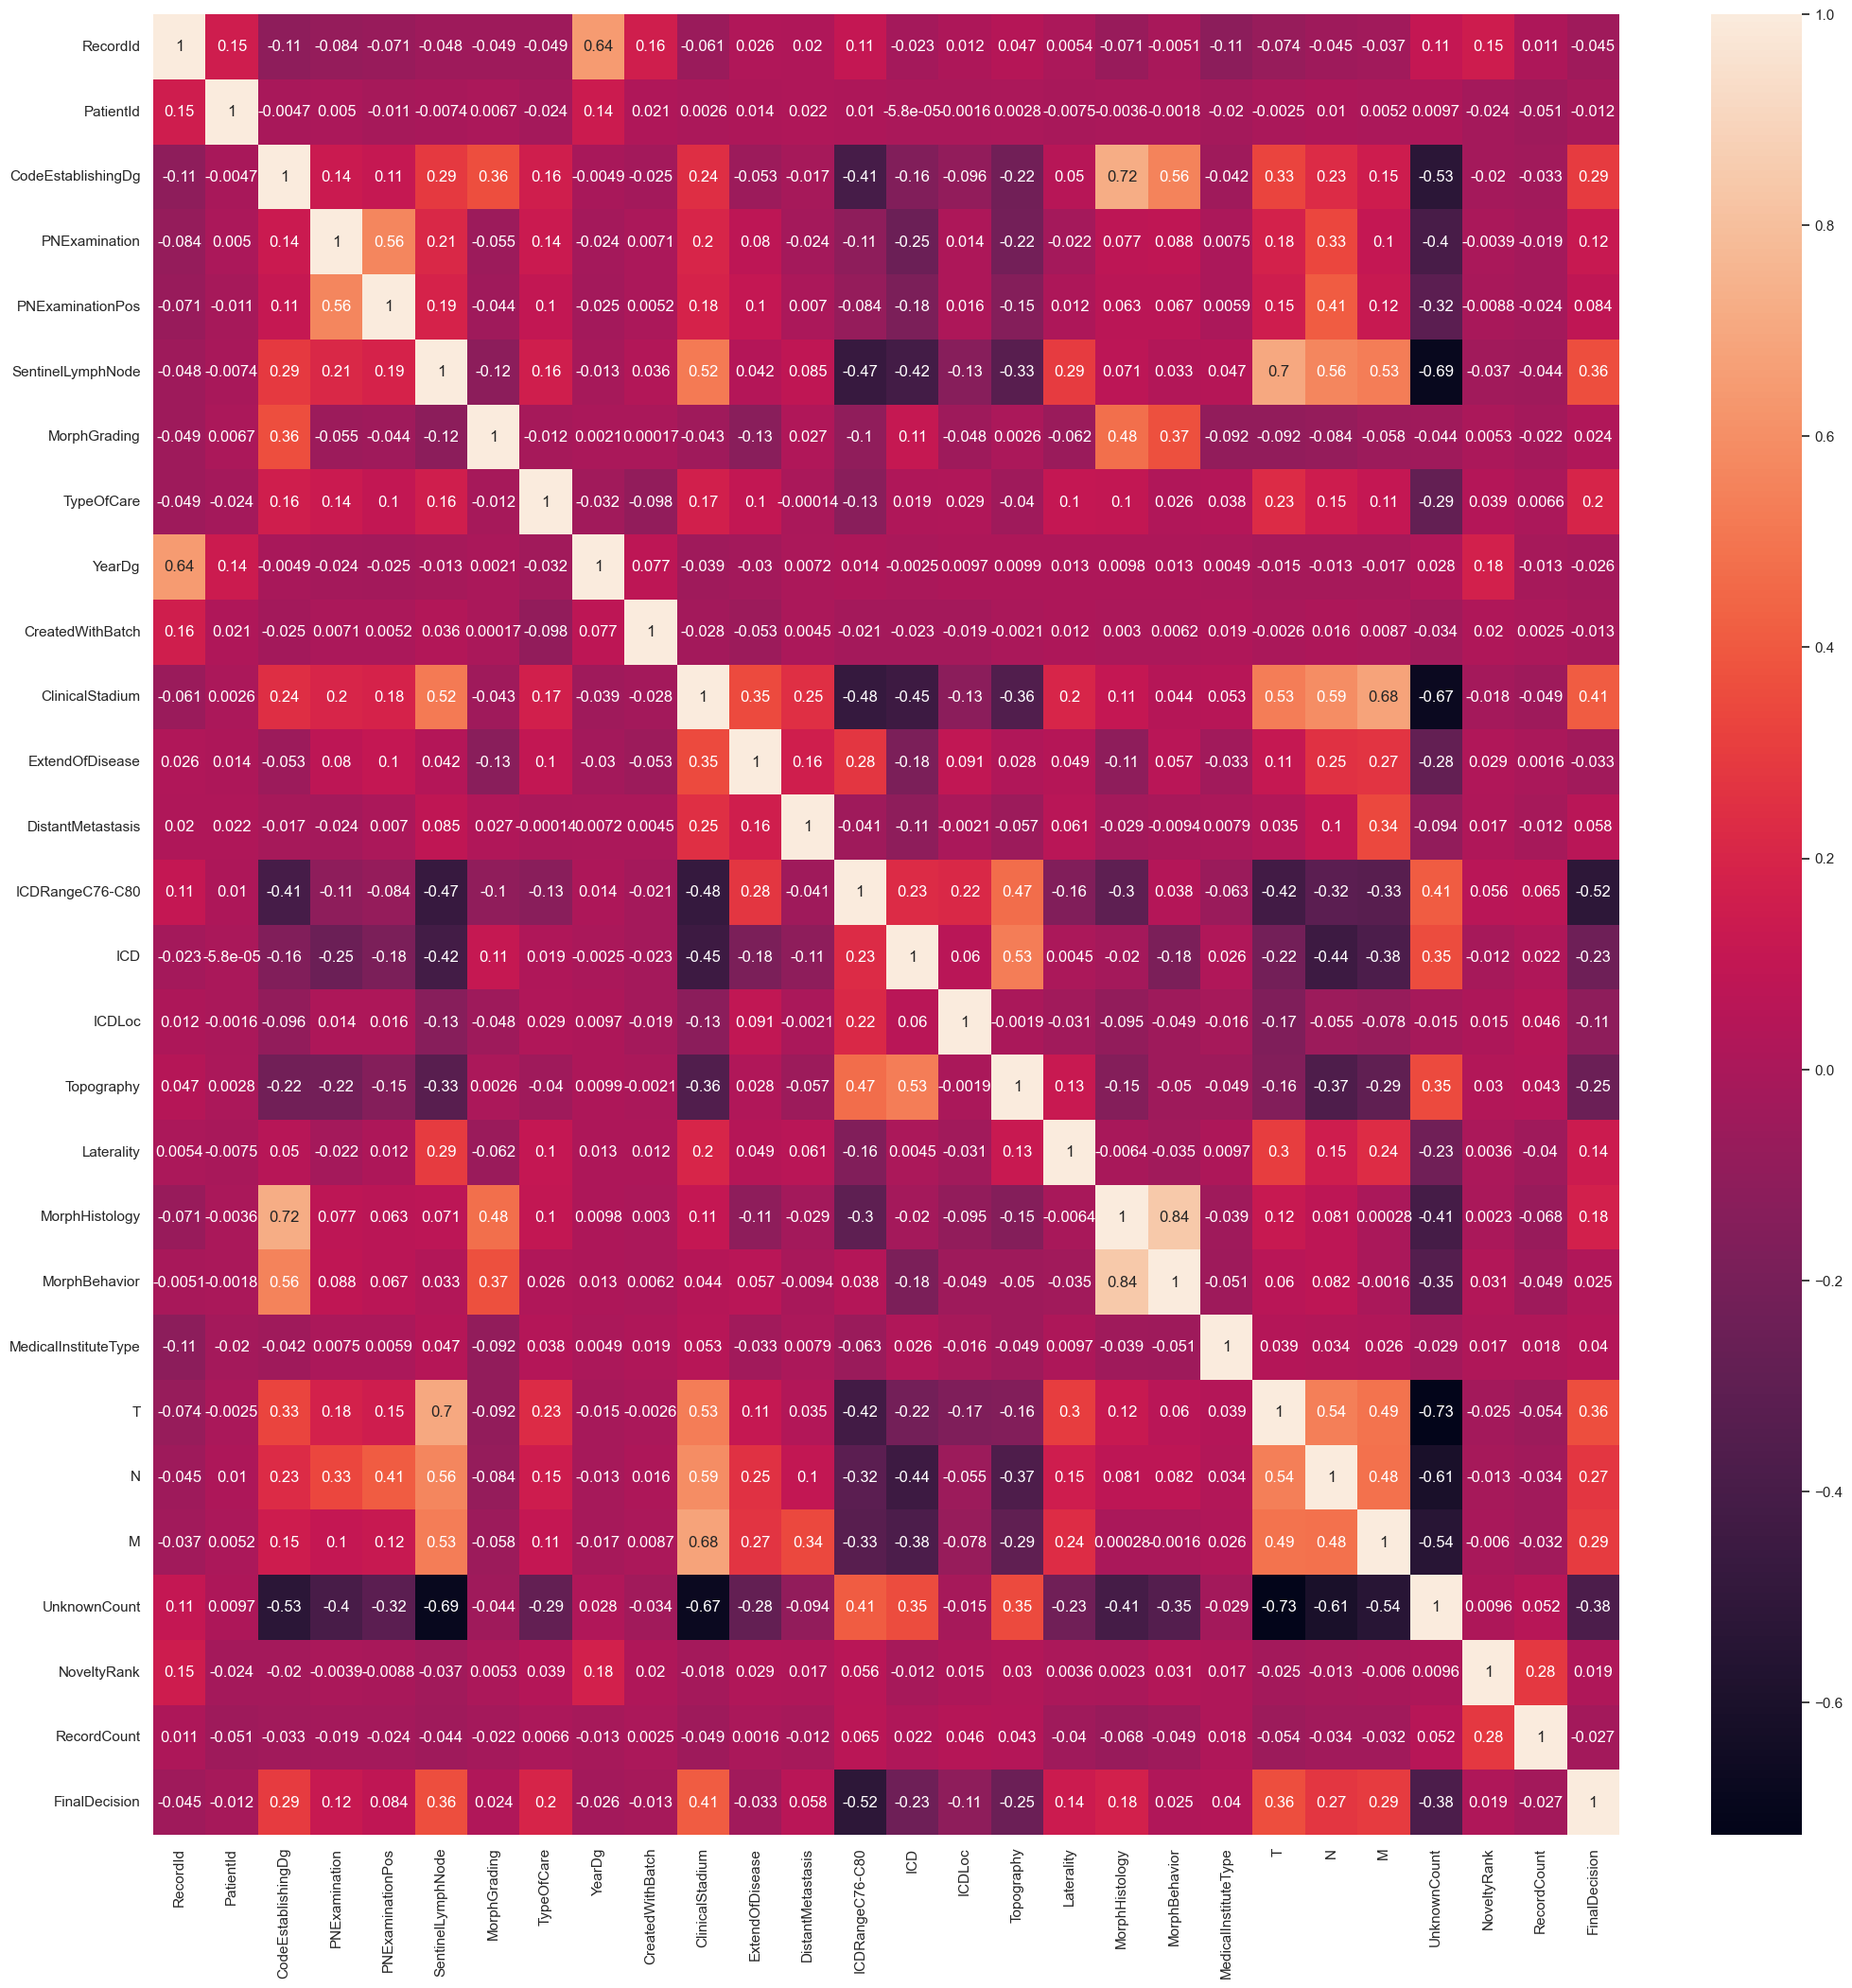

In [19]:
import seaborn as sns

corr_df = data_ready.corr(method="pearson")

# Plot the correlation matrix
_, ax = plt.subplots(figsize=(25, 25))

sns.heatmap(corr_df, annot=True, ax=ax)

None

### Top Correlations

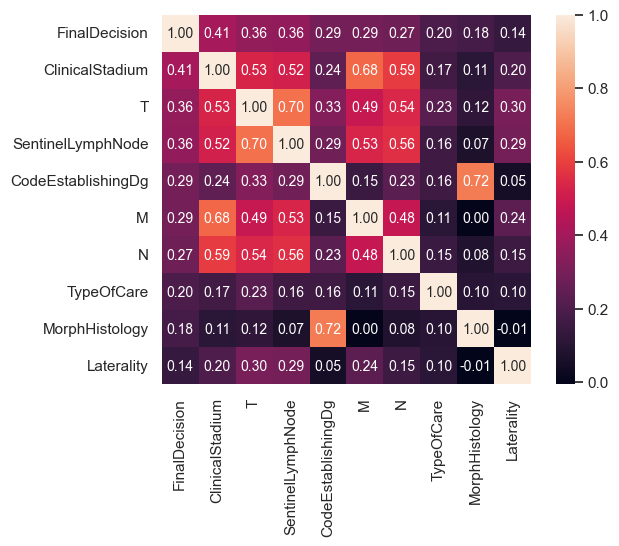

In [21]:
k = 10 # Number of variables for heatmap
cols = corr_df.nlargest(k, "FinalDecision")["FinalDecision"].index
cm = np.corrcoef(data_ready[cols].values.T)

sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=cols.values,
    xticklabels=cols.values,
)
None

In [23]:
# Take significant correlations from the correlation matrix
signf = []
for col in corr_df.columns:
    if abs(corr_df[col]["FinalDecision"]) > 0.1:
        signf.append((corr_df[col]["FinalDecision"], col))

for _, col in sorted(signf, key=lambda x: x[0], reverse=True):
    print(col, round(corr_df[col]["FinalDecision"], 2))

FinalDecision 1.0
ClinicalStadium 0.41
T 0.36
SentinelLymphNode 0.36
CodeEstablishingDg 0.29
M 0.29
N 0.27
TypeOfCare 0.2
MorphHistology 0.18
Laterality 0.14
PNExamination 0.12
ICDLoc -0.11
ICD -0.23
Topography -0.25
UnknownCount -0.38
ICDRangeC76-C80 -0.52


## Null values

### TMN Values

In [28]:
# Print the unique values of columns
to_print = ["T", "M", "N"]

for cat in to_print:
    print("Columns with category", cat)
    print(sorted(data_by_expert[cat].astype("str").unique()))
    print()

print(data_by_expert["T"].value_counts(dropna=False)[:6])

# Replace x to X in clumns T, M, N
data_by_expert[["T", "M", "N"]] = data_by_expert[["T", "M", "N"]].replace(
    "x", "X"
)

Columns with category T
['0', '1', '1a', '1a1', '1a2', '1b', '1b1', '1b2', '1c', '1c1', '1c2', '1c3', '1m', '2', '2a', '2a1', '2a2', '2b', '2c', '3', '3a', '3b', '3c', '4', '4a', '4b', '4c', '4d', 'X', 'a', 'is', 'isD', 'isL', 'isP', 'nan', 'x']

Columns with category M
['0', '1', '1a', '1b', '1c', '1d', 'X', 'nan']

Columns with category N
['0', '1', '1a', '1b', '1c', '2', '2a', '2b', '2c', '3', '3a', '3b', '3c', 'X', 'nan', 'x']

T
X      6017
NaN    5965
3      1997
2      1322
1      1099
4       875
Name: count, dtype: int64


## Relationships of Features with FinalDecision

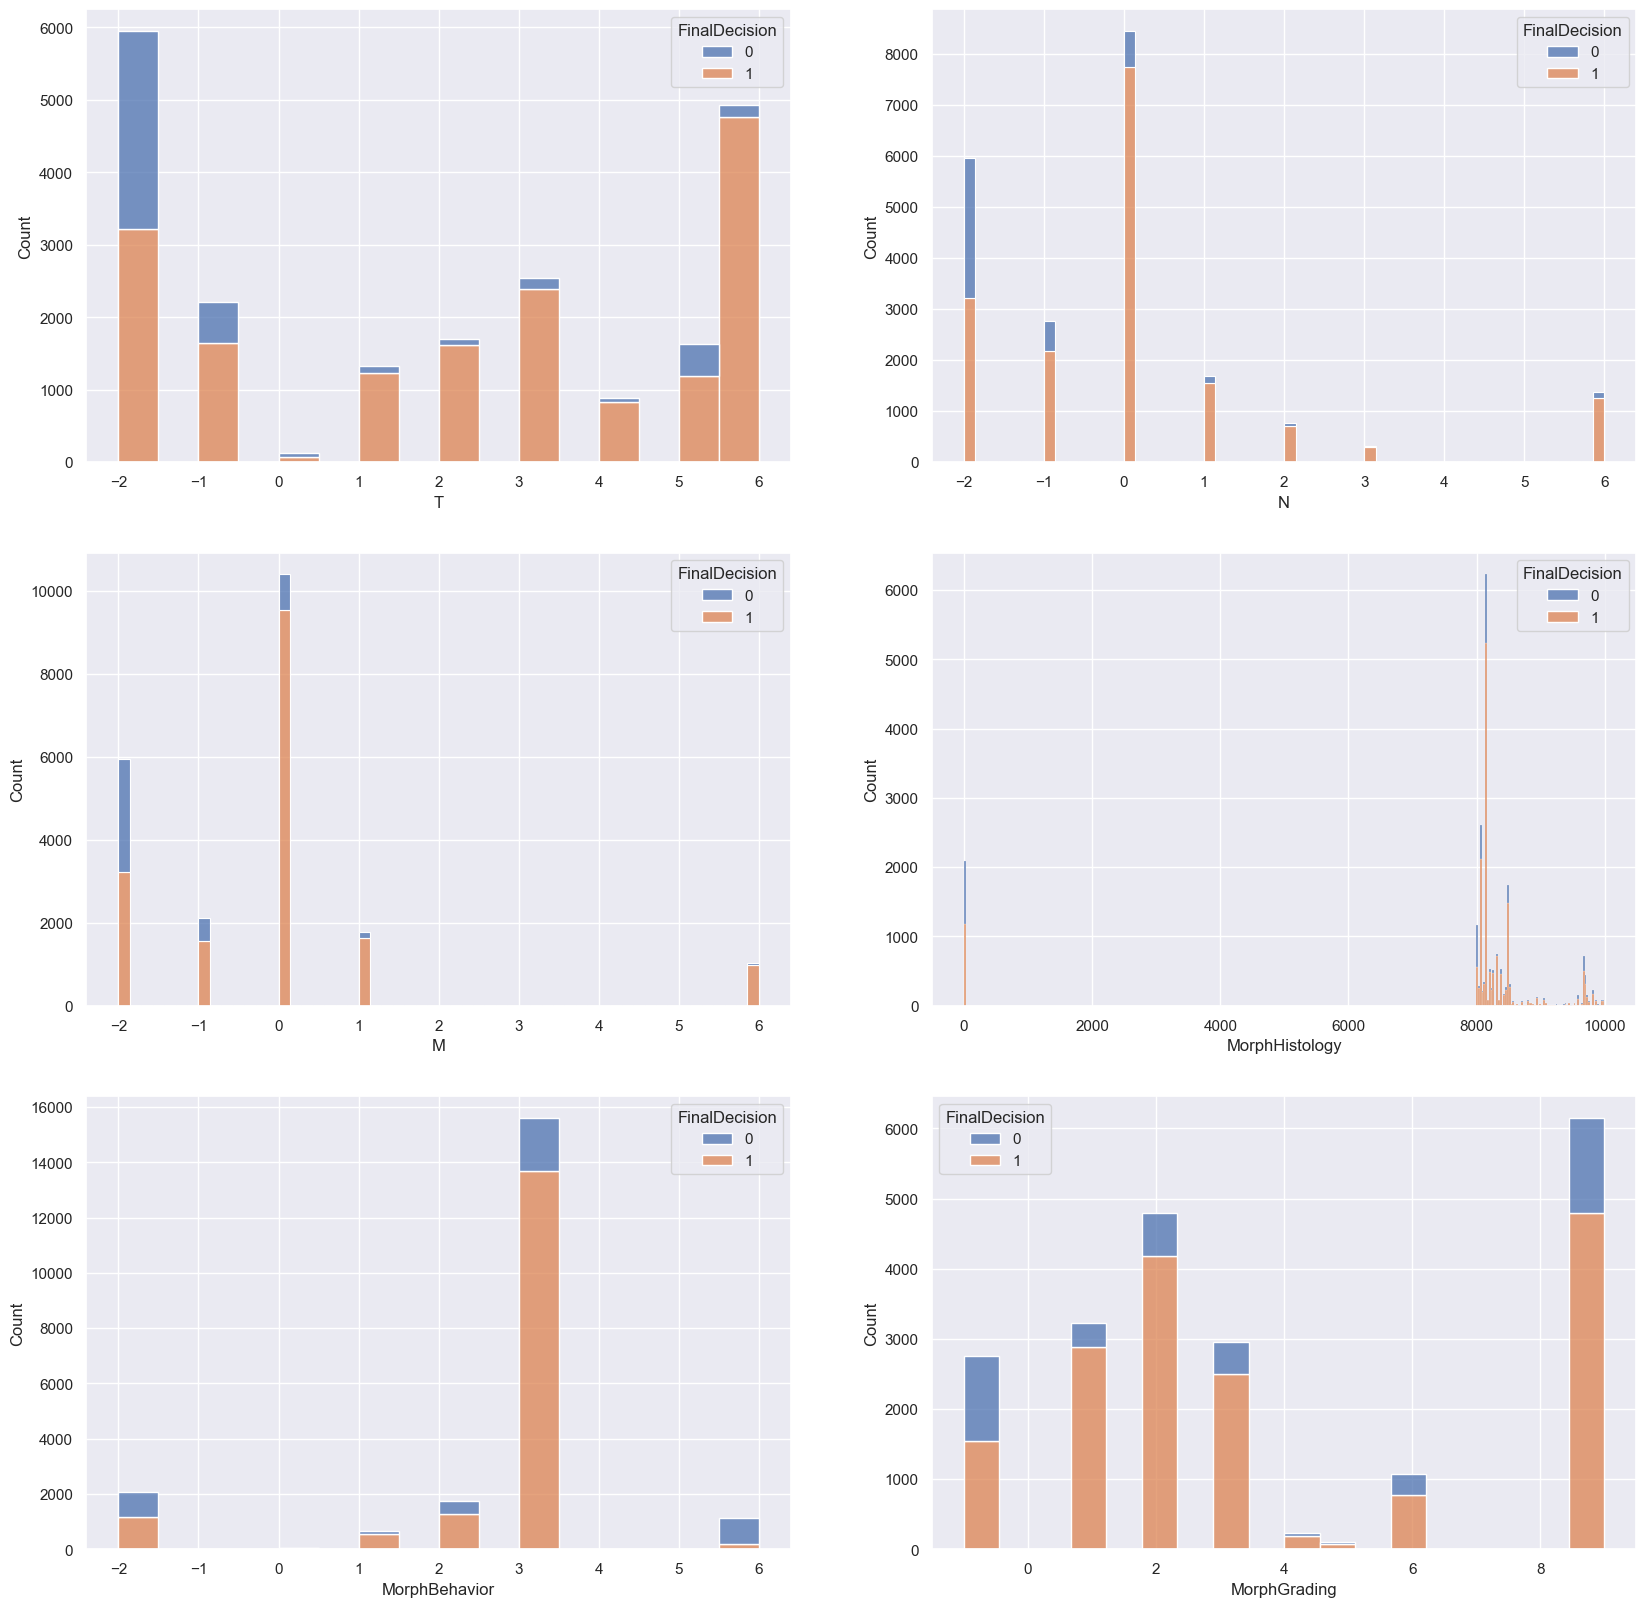

In [38]:
def plot_histo_with_y(data: pd.DataFrame, x_vars: list[str], n_cols: int = 1, n_rows: int = 1):
    _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

    for i, x_var in enumerate(x_vars):
        sns.histplot(
            data=data,
            x=x_var,
            ax=axes[i // n_cols, i % n_cols],
            hue="FinalDecision",
            multiple="stack",
        )


# Plot the histograms
to_plot = [
    "T",
    "N",
    "M",
    "MorphHistology",
    "MorphBehavior",
    "MorphGrading",
]

plot_histo_with_y(data_ready, to_plot, n_cols=2, n_rows=3)

## Group Records of Patients

In [5]:
def get_grouped_data_by_patient(data: pd.DataFrame) -> pd.DataFrame:
    aggregations = [
        "count",
        "sum",
        lambda x: x.count() - x.sum(),
    ]

    # Group by the columns ["PacientId"] and sum "vyporadani_final"
    data_grouped_by_patient = (
        data.groupby(["PatientId"])["FinalDecision"]
        .agg(aggregations)
        .rename(columns={"<lambda_0>": "incorrect", "sum": "correct"})
        .astype(int)
        .sort_values(by="count", ascending=False)
    )

    return data_grouped_by_patient


def get_data_grouped_by_count(data: pd.DataFrame) -> pd.DataFrame:
    df = get_grouped_data_by_patient(data).groupby("count").sum()
    df["sum"] = df["correct"] + df["incorrect"]
    return df


data_grouped_by_patient = get_grouped_data_by_patient(data_ready_only_algo_filtered)

print("Shape: ", data_grouped_by_patient.shape)
data_grouped_by_patient.head()

Shape:  (10330, 3)


,count,correct,incorrect
PatientId,,,
2473380,8,7,1
2864333,7,6,1
2964425,6,4,2
3021262,6,6,0
3054088,6,6,0


In [83]:
get_data_grouped_by_count(data_ready_only_algo_filtered).head()

,correct,incorrect,sum
count,,,
1,1414,63,1477
2,14627,3649,18276
3,2324,697,3021
4,458,146,604
5,113,27,140


In [77]:
data_grouped_by_patient.describe().T

,count,mean,std,min,25%,50%,75%,max
count,11807.0,1.995172,0.541730,1.0,2.0,2.0,2.0,8.0
correct,11807.0,1.606759,0.633311,0.0,1.0,2.0,2.0,7.0
incorrect,11807.0,0.388414,0.534015,0.0,0.0,0.0,1.0,3.0


In [78]:
print("Number of entries per patient:")
# Print value counts sorted by index
print(data_grouped_by_patient["count"].value_counts().sort_index())

Number of entries per patient:
count
1    1477
2    9138
3    1007
4     151
5      28
6       4
7       1
8       1
Name: count, dtype: int64


### Pie charts

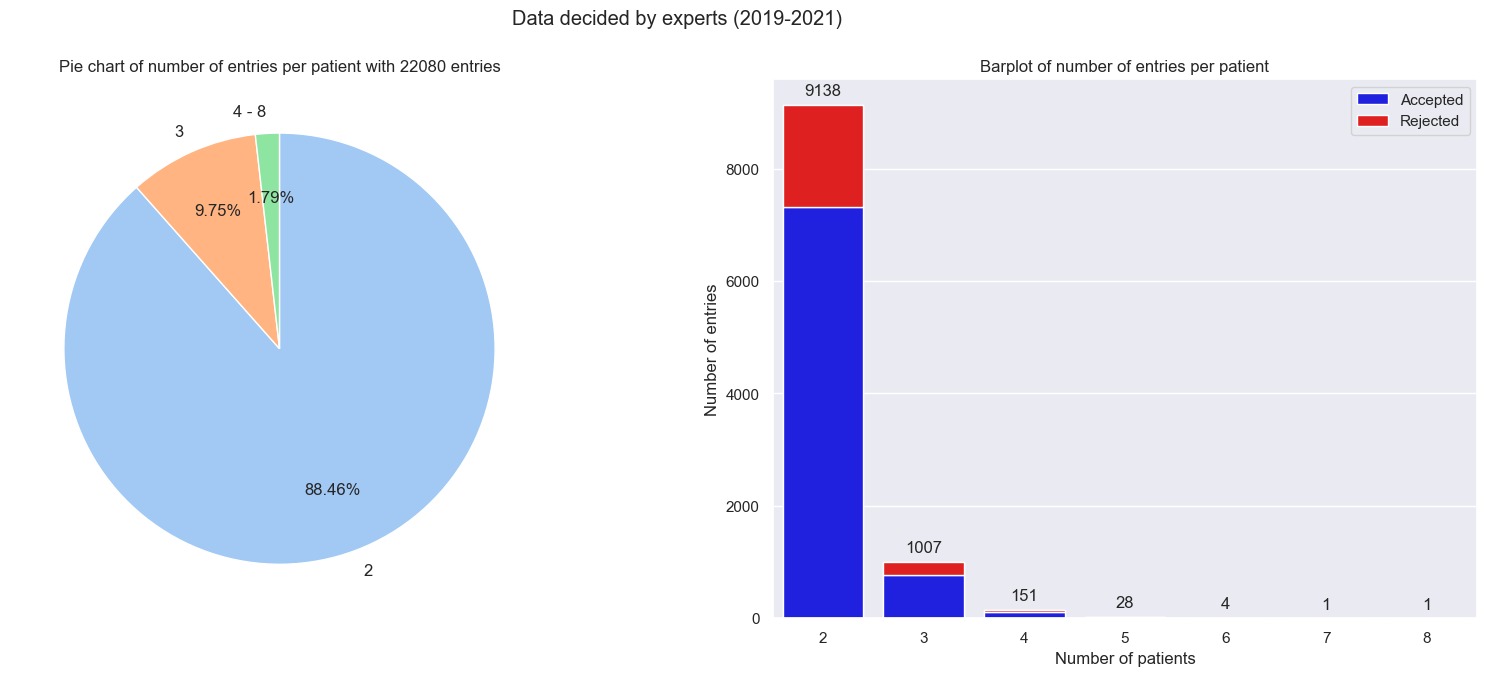

In [15]:
def entry_bar_plot(data: pd.DataFrame, ax: plt.Axes | None = None) -> None:

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))

    count_df = get_data_grouped_by_count(data)
    for col in ["sum", "correct", "incorrect"]:
        count_df[col] = count_df[col] / count_df.index

    ax.set_title("Barplot of number of entries per patient")
    sns.barplot(
        count_df,
        x=count_df.index,
        y=count_df["sum"],
        palette="pastel",
        hue=count_df.index,
        legend=False,
        ax=ax,
    )

    # Annotate bar plot

    for p in ax.patches:
        ax.annotate(
            # Annotate the sum
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    # Draw lower bars
    sns.barplot(
        data=count_df,
        x=count_df.index,
        y=count_df["correct"],
        color="blue",
        ax=ax,
        label="Accepted",
    )

    # Draw upper bars
    sns.barplot(
        data=count_df,
        x=count_df.index,
        y=count_df["incorrect"],
        bottom=count_df["correct"],
        color="red",
        ax=ax,
        label="Rejected",
    )

    # Set y title
    ax.set_xlabel("Number of patients")
    ax.set_ylabel("Number of entries")


def pie_chart_plot(
    data: pd.DataFrame, title: str | None = None, ax: plt.Axes | None = None
) -> None:

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    pie_df = get_data_grouped_by_count(data)

    # Sum the rows from take_n and above
    take_n = 4
    to_take = pie_df.index[pie_df.index >= take_n]

    pie_df["patients"] = pie_df["sum"] / pie_df.index
    pie_df.loc[take_n, "patients"] = pie_df.loc[to_take, "patients"].sum()

    max_index = pie_df.index.max()

    pie_df = pie_df.loc[pie_df.index <= take_n]

    # Rename the index
    pie_df = pie_df.rename(index={take_n: f"{take_n} - {max_index}"})
    pie_df.index = pie_df.index.astype(str)

    # Draw a pie chart
    ax.pie(
        pie_df["patients"],
        labels=pie_df.index,
        autopct="%.2f%%",
        pctdistance=0.7,
        # textprops={"fontsize": 9},
        textprops={"fontsize": 12},
        colors=sns.color_palette("pastel"),
        startangle=90,
        counterclock=False,
    )

    ax.set_title(
        f"Percentage of patients with respect to number of entries per patient"
    )

    if title is not None:
        ax.set_title(title)


def entry_pie_chart_bar_plot(
    data: pd.DataFrame, title: str | None = None
) -> None:

    fig, axes = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)

    # Set title of the figure
    if title is not None:
        fig.suptitle(title)

    entry_bar_plot(data, ax=axes[1])
    pie_chart_plot(
        data,
        ax=axes[0],
        title=f"Pie chart of number of entries per patient with {len(data)} entries",
    )


entry_pie_chart_bar_plot(
    data_ready_only_algo_filtered, title="Data decided by experts (2019-2021)"
)
# entry_bar_plot(data_ready_only_algo_filtered)

### Acceptance pies

In [58]:
def get_entry_correct_count_table(
    df: pd.DataFrame, entries_count: int, verbose=False
) -> pd.DataFrame:
    """
    Get a table of patients with a specific number of entries and
    the number of correct entries

    Parameters:
    df: pd.DataFrame
        Dataframe with the data
    entries_count: int
        Number of entries to filter by
    verbose: bool
        Print the table
    """

    data_grouped_by_patient = get_grouped_data_by_patient(df)

    entry_val_counts = (
        data_grouped_by_patient[data_grouped_by_patient["count"] == entries_count]
        .value_counts()
        .reset_index(level=["count", "incorrect"], drop=True)
        .to_frame()
    )

    # Add percentage column to series
    all_sum = entry_val_counts["count"].sum()
    entry_val_counts["%"] = entry_val_counts["count"] / all_sum * 100
    entry_val_counts["%"] = entry_val_counts["%"].round(2)
    entry_val_counts["sum"] = all_sum

    if verbose:
        print(
            f"Table for patients with {entries_count} entry/entries, total number of patients: {all_sum}"
        )
        print(entry_val_counts)
        print(30 * "-")

    return entry_val_counts.sort_index()


get_entry_correct_count_table(data_ready, 2)

,count,%,sum
correct,,,
0,17,0.19,9138
1,3615,39.56,9138
2,5506,60.25,9138


In [59]:
def plot_reports_acceptance_pies(
    data: pd.DataFrame,
    nrows: int,
    ncols: int,
    dataset_name: str | None = None,
    to_draw: int | None = None,
) -> None:
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows)
    )

    # fig.suptitle(
    #     f"Number of accepted reports according to count of entries per patient ({dataset_name if dataset_name is not None else ''})"
    # )

    counts = sorted(data["RecordCount"].unique())

    if len(counts) > nrows * ncols:
        counts = counts[: nrows * ncols]

    # Draw pie charts for each entry count
    for i, count in enumerate(counts):
        if i == to_draw:
            for j in range(i, len(counts)):
                fig.delaxes(
                    axes[j // ncols, j % ncols] if nrows > 1 else axes[j]
                )

            break

        table = get_entry_correct_count_table(data, count, verbose=False)

        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        ax.set_title(
            f"{count} records per patient, {table['sum'].iloc[0]} patients"
        )

        def my_autopct(pct):
            return "{:.1f}%".format(pct) if pct > 1 else ""

        ax.pie(
            table["count"],
            labels=table.index,
            # autopct="%.2f%%",
            autopct=my_autopct,
            startangle=90,
            counterclock=False,
        )

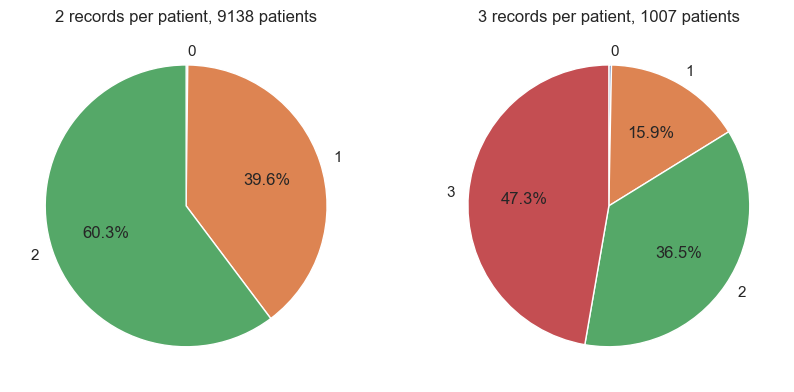

In [91]:
plot_reports_acceptance_pies(
    data_ready, 1, 2, dataset_name="Data by expert (2019-2021)", to_draw=2
)